In [1]:
import tensorflow as tf
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import random
from tqdm import tqdm
mpl.rcParams['figure.dpi'] = 250

k562_bpnet = tf.keras.models.load_model('/content/k562_chrombpnet_wo_bias.h5', compile=False)
gm12878_bpnet = tf.keras.models.load_model('/content/gm12878_chrombpnet_wo_bias.h5', compile=False)
hepg2_bpnet = tf.keras.models.load_model('/content/hepg2_chrombpnet_wo_bias.h5', compile=False)
h1esc_bpnet = tf.keras.models.load_model('/content/h1esc_chrombpnet_wo_bias.h5', compile=False)
df = pd.read_csv('/content/processed_data_removed.txt')

2023-01-27 01:31:34.197404: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 01:31:34.288295: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 01:31:34.289083: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 01:31:34.290999: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# Extending Sequences to length 2114

In [2]:
!pip install ucsc_genomes_downloader
from ucsc_genomes_downloader import Genome
hg38 = Genome(assembly="hg38")

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 1.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for ucsc_genomes_downloader: filename=ucsc_genomes_downloader-1.1.26-py3-none-any.whl size=14974 sha256=42956dea5ecbb7f45502bad0a6e0309454fb994ac9d8b493f2fbab791b271a86
  Stored in directory: /root/.cache/pip/wheels/37/b6/77/31467f98789328aab176cbde40dcf81386855ad65bf235a853
  Created wheel for compress_json: filename=compress_json-1.0.8-py3-none-any.whl size=4730 sha256=e9a003b023b1e35eb9955bbf110fae4099f8187aeada23d8243d9c6cf8cd9475
  Stored in directory: /root/.cache/pip/wheels/93/9f/a4/13810037c24ad31f1f42fe769d4cbe6665d8d081c322b3483b
  Created wheel for 

Loading chromosomes for genome hg38:   0%|          | 0/25 [00:00<?, ?it/s]

In [3]:
df = df.rename(columns={'chr': 'chrom', 'start': 'chromStart', 'end': 'chromEnd'})
df = df.drop(['sequence'], axis=1)

a = []
b = []
for ind, row in df.iterrows():
    flank_len = (2114 - (row['chromEnd'] - row['chromStart']))//2
    a1 = row['chromEnd'] + flank_len
    b1 = row['chromStart'] - flank_len
    if a1 - b1 == 2113:
        b1 -= 1
    elif a1 - b1 == 2115:
        b1 += 1
    b.append(b1)
    a.append(a1)
df['chromEnd'] = a
df['chromStart'] = b

sequences = hg38.bed_to_sequence(df)
for i in range(len(sequences)):
    sequences[i] = sequences[i].upper()

df['Full_Sequence'] = sequences
df.to_csv('processed_data.txt', sep=',', header=True)
indices = []
for i, j in enumerate(sequences):
    if len(j) != 2114: indices.append(i)
df_removed = df.drop(indices)
df.to_csv('processed_data_removed.txt', sep=',', header=True, index=False)

# Shuffling DNA Sequences (getting negative sequences)

In [4]:
full_sequences = df['Full_Sequence']
shuffled_sequences = []
for i in range(len(full_sequences)):
    if type(full_sequences[i]) == str:
        shuffled_sequences.append(''.join(random.sample(full_sequences[i], len(full_sequences[i]))))
    else:
        shuffled_sequences.append(full_sequences[i])

df['Shuffled_Sequence'] = shuffled_sequences

# Running chrombpnet

In [9]:
def preprocess_sequence(seq):
    letter2ind = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    sequence = []
    for i in range(2114): sequence.append(letter2ind[seq[i]])
    sequence = np.array(sequence)
    b = np.zeros((sequence.size, sequence.max() + 1))
    b[np.arange(sequence.size), sequence] = 1
    return b[None, :]

In [5]:
def plot_chrom_accessibility(k562_output, gm12878_output, hepg2_output, h1esc_output, window=200):
    one_kb_window = int((window//2)/2114*1000)
    plt.plot(list(range(94)), k562_output[0][0, 500-one_kb_window:500+one_kb_window], "r-")
    plt.plot(list(range(94)), gm12878_output[0][0, 500-one_kb_window:500+one_kb_window], "g-")
    plt.plot(list(range(94)), hepg2_output[0][0, 500-one_kb_window:500+one_kb_window], "b-")
    plt.plot(list(range(94)), h1esc_output[0][0, 500-one_kb_window:500+one_kb_window], "y-")
    plt.title('Chromatin Accessibility')

In [23]:
heatmap = []
labels = []

for row_num, row in tqdm(df.iterrows(), total=df.shape[0]):
    curr_seq = row['Full_Sequence']
    if type(curr_seq) != str or 'N' in curr_seq: continue
    curr_seq = preprocess_sequence(curr_seq)
    cell_type = row['TAG'][:row['TAG'].index('_')]
    for a, seq in enumerate([curr_seq, preprocess_sequence(row['Shuffled_Sequence'])]):
        gm12878_output = np.mean(gm12878_bpnet(seq)[0][0, 453:547])
        h1esc_output = np.mean(h1esc_bpnet(seq)[0][0, 453:547])
        k562_output = np.mean(k562_bpnet(seq)[0][0, 453:547])
        hepg2_output = np.mean(hepg2_bpnet(seq)[0][0, 453:547])
        heatmap.append([gm12878_output, h1esc_output, k562_output, hepg2_output])
        if a == 0: labels.append(cell_type + str(row_num))
        else: labels.append('Random' + str(row_num))

heatmap = np.array(heatmap)

  0%|          | 3/47872 [00:00<3:13:36,  4.12it/s]

[[6.1110296  0.06234744 4.4588747  7.2809105 ]
 [4.8860483  0.6781624  3.9232087  7.059345  ]
 [6.2353735  1.1419221  4.784363   7.2673516 ]
 [4.1554236  0.33105892 4.736819   7.0769954 ]
 [5.4612374  0.94162387 5.069739   8.338973  ]
 [6.172267   1.9062396  6.1003323  8.698946  ]
 [4.743805   0.4258951  3.9243655  6.798511  ]
 [3.5613897  0.973553   4.002676   6.174018  ]]


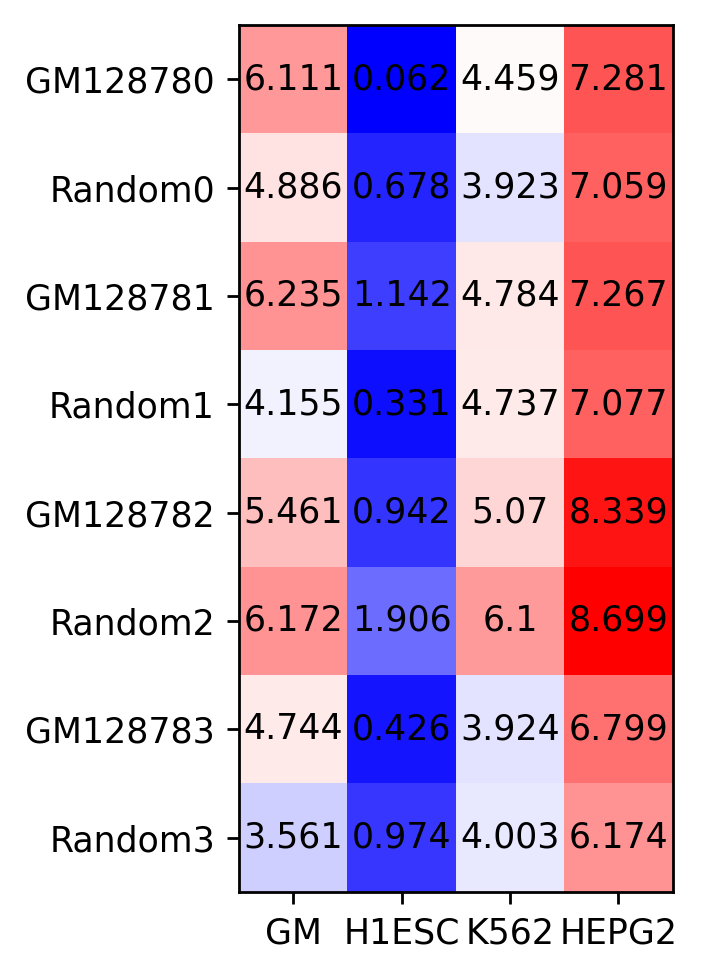

In [35]:
cell_type = ["GM", "H1ESC", "K562", "HEPG2"]
fig, ax = plt.subplots()
im = ax.imshow(heatmap, cmap=mpl.colormaps['bwr'])
ax.set_xticks(np.arange(len(cell_type)), labels=cell_type)
ax.set_yticks(np.arange(len(labels)), labels=labels)

for i in range(len(labels)):
    for j in range(len(cell_type)):
        text = ax.text(j, i, round(heatmap[i, j], 3), ha="center", va="center", color="black")
fig.tight_layout()
plt.show()